## Task

>This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions.

>1. Data cleaning
>2. Gather some interesting overall insights about the data. 
    For example -- what is the average transaction amount? How many transactions do customers make each month, on average?
>3. Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an average day or week. Consider the effect of any outliers that may distort your analysis.
>4. For a challenge – what insights can you draw from the location information provided in the dataset?

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
# set astheticsc
sns.set()

In [3]:
# import data
df = pd.read_csv('ANZ_synthesised_transaction_dataset.csv')

### Overall EDA

In [4]:
# Summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             12043 non-null  object 
 1   card_present_flag  7717 non-null   float64
 2   bpay_biller_code   885 non-null    object 
 3   account            12043 non-null  object 
 4   currency           12043 non-null  object 
 5   long_lat           12043 non-null  object 
 6   txn_description    12043 non-null  object 
 7   merchant_id        7717 non-null   object 
 8   merchant_code      883 non-null    float64
 9   first_name         12043 non-null  object 
 10  balance            12043 non-null  float64
 11  date               12043 non-null  object 
 12  gender             12043 non-null  object 
 13  age                12043 non-null  int64  
 14  merchant_suburb    7717 non-null   object 
 15  merchant_state     7717 non-null   object 
 16  extraction         120

> extraction and date is in the wrong format

In [5]:
# take a look at the data
df.head(3)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit


In [6]:
# convert date data from string to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

<AxesSubplot:xlabel='date', ylabel='Count'>

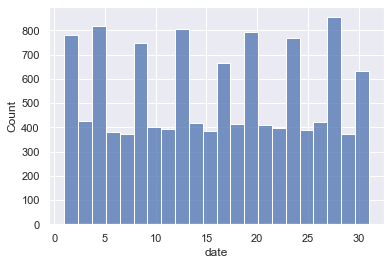

In [7]:
# double check the transformation (check for irregularity in the distribution of days)
sns.histplot(df['date'].dt.day)

In [8]:
# summary of date
df['date'].describe(datetime_is_numeric=True)

count                            12043
mean     2018-09-15 21:27:39.951839232
min                2018-08-01 00:00:00
25%                2018-08-24 00:00:00
50%                2018-09-16 00:00:00
75%                2018-10-09 00:00:00
max                2018-10-31 00:00:00
Name: date, dtype: object

In [9]:
# check for missing date
pd.date_range(start=df['date'].min(), end=df['date'].max()).difference(df['date'])

DatetimeIndex(['2018-08-16'], dtype='datetime64[ns]', freq=None)

> data for the date '2018-08-16' is missing

In [10]:
df.columns

Index(['status', 'card_present_flag', 'bpay_biller_code', 'account',
       'currency', 'long_lat', 'txn_description', 'merchant_id',
       'merchant_code', 'first_name', 'balance', 'date', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'country', 'customer_id', 'merchant_long_lat',
       'movement'],
      dtype='object')

#### Categorical data

In [11]:
for item in ['status', 'currency', 'txn_description', 'gender', 'merchant_state', 'country']:
    print(df[item].value_counts())

authorized    7717
posted        4326
Name: status, dtype: int64
AUD    12043
Name: currency, dtype: int64
SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64
M    6285
F    5758
Name: gender, dtype: int64
NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merchant_state, dtype: int64
Australia    12043
Name: country, dtype: int64


#### Numeric data

In [12]:
df['age'].describe()

count    12043.000000
mean        30.582330
std         10.046343
min         18.000000
25%         22.000000
50%         28.000000
75%         38.000000
max         78.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

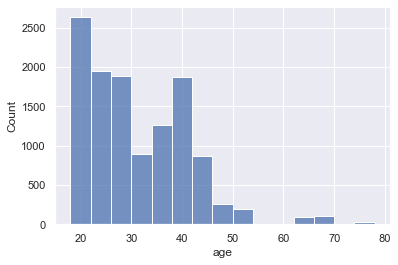

In [53]:
sns.histplot(df['age'], bins=15)

In [14]:
df['amount'].describe()

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64

<AxesSubplot:ylabel='amount'>

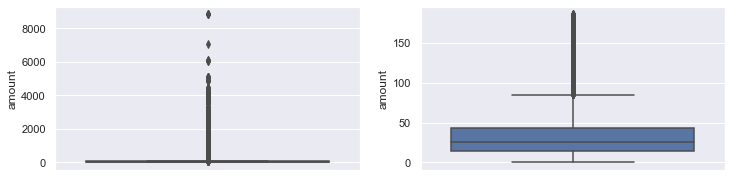

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
sns.boxplot(y=df['amount'], ax=axes[0])
q_high = df['amount'].quantile(0.9) 
sns.boxplot(y=df[df['amount'] < q_high]['amount'], ax=axes[1])

[Text(0, 0, 'POS'),
 Text(1, 0, 'SALES-POS'),
 Text(2, 0, 'PAYMENT'),
 Text(3, 0, 'INTER BANK'),
 Text(4, 0, 'PAY/SALARY'),
 Text(5, 0, 'PHONE BANK')]

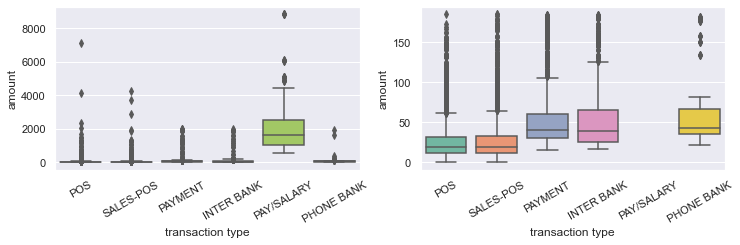

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
sns.boxplot(data=df, y=df['amount'], x='txn_description', palette='Set2', ax=axes[0])
sns.boxplot(data=df, y=df[df['amount']<q_high]['amount'], x='txn_description', palette='Set2', ax=axes[1])
axes[0].set_xlabel('transaction type')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=30)
axes[1].set_xlabel('transaction type')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=30)

> We can see that the distribution for PAY/SALARY is very distinct and should be analysed separately.

<AxesSubplot:xlabel='amount', ylabel='Count'>

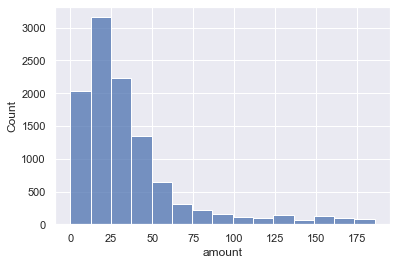

In [52]:
sns.histplot(x=df[(df['amount'] < q_high)]['amount'], bins=15)

In [18]:
# check the uniqueness of transaction_id
df['transaction_id'].nunique()

12043

In [19]:
# check the one to one relationship of account to customer_id
df[['account', 'customer_id']].nunique()

account        100
customer_id    100
dtype: int64

In [20]:
df[['date', 'extraction']].tail()

,date,extraction
12038,2018-10-31,2018-10-31T23:09:06.000+0000
12039,2018-10-31,2018-10-31T23:21:46.000+0000
12040,2018-10-31,2018-10-31T23:34:25.000+0000
12041,2018-10-31,2018-10-31T23:47:05.000+0000
12042,2018-10-31,2018-10-31T23:59:44.000+0000


In [21]:
# convert extration from string to datetime
df['extraction'] = pd.to_datetime(df['extraction'])

Text(0, 0.5, 'volume')

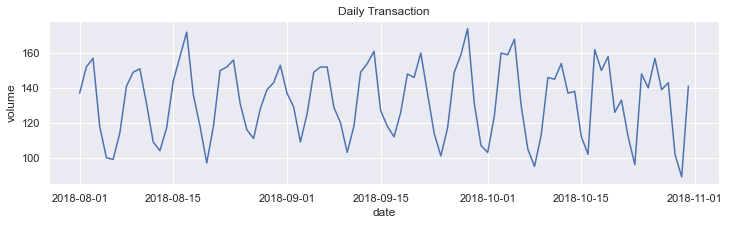

In [22]:
# daily transaction volume
plt.figure(figsize=(12, 3))
df_day = df.groupby('date').agg({'transaction_id':'count', 'amount':'sum'})
sns.lineplot(data=df_day, x='date', y='transaction_id')
plt.title('Daily Transaction')
plt.ylabel('volume')

> Sesonality show in daily transaction amount.

In [23]:
# extract hour from extraction (transaction timestamp)
df['hour'] = df['extraction'].dt.hour
df[['extraction', 'hour']].head()

,extraction,hour
0,2018-08-01 01:01:15+00:00,1
1,2018-08-01 01:13:45+00:00,1
2,2018-08-01 01:26:15+00:00,1
3,2018-08-01 01:38:45+00:00,1
4,2018-08-01 01:51:15+00:00,1


In [24]:
# extract week day from extraction
df['weekday'] = df['extraction'].dt.weekday
df[['extraction', 'weekday']].head()

,extraction,weekday
0,2018-08-01 01:01:15+00:00,2
1,2018-08-01 01:13:45+00:00,2
2,2018-08-01 01:26:15+00:00,2
3,2018-08-01 01:38:45+00:00,2
4,2018-08-01 01:51:15+00:00,2


In [25]:
# transacton count and amount by weekday
df_weekday = df.groupby('weekday').agg({'transaction_id':'count', 'amount':'sum'})
df_weekday.head()

,transaction_id,amount
weekday,,
0,1360,507580.56
1,1487,329484.19
2,2063,402729.72
3,1801,331402.77
4,2073,516909.84


Text(0, 0.5, 'transaction volume')

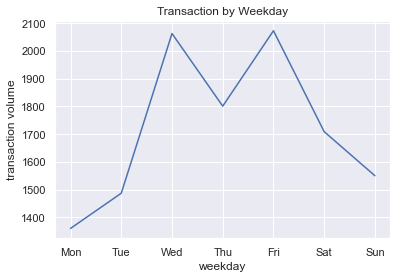

In [26]:
# weekly transaction volume
g = sns.lineplot(data=df_weekday, x='weekday', y='transaction_id')
plt.title('Transaction by Weekday')
plt.xticks(ticks=df_weekday.index, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('transaction volume')

In [27]:
# transacton count and amount by hour
df_hour = df.groupby('hour').agg({'transaction_id':'count', 'amount':'sum'})
df_hour.head()

,transaction_id,amount
hour,,
0,108,3053.69
1,214,10425.31
2,212,15957.19
3,196,16606.28
4,309,18942.27


Text(0, 0.5, 'transaction volume')

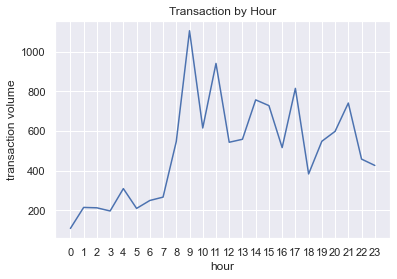

In [28]:
# hourly transaction volume
g = sns.lineplot(data=df_hour, x='hour', y='transaction_id')
plt.xticks(np.arange(min(df['hour']), max(df['hour'])+1, 1.0))
plt.title('Transaction by Hour')
plt.ylabel('transaction volume')

#### Missing data

In [29]:
# Missing value summary
missing = df.isnull().sum()
missing = missing[missing > 0]
missing_percentage = round(missing/df.shape[0]*100,2)
pd.DataFrame({"na_count": missing, "na_%": missing_percentage}).sort_values(by = "na_%", ascending = False)

,na_count,na_%
merchant_code,11160,92.67
bpay_biller_code,11158,92.65
card_present_flag,4326,35.92
merchant_id,4326,35.92
merchant_suburb,4326,35.92
merchant_state,4326,35.92
merchant_long_lat,4326,35.92


> merchant info are missing for non-purchasing transactions.

### Subgroup trasactions EDA (purchase and salary)

In [30]:
df.groupby('txn_description').agg({'transaction_id':'count', 'amount':'mean'})

,transaction_id,amount
txn_description,,
INTER BANK,742,86.699461
PAY/SALARY,883,1898.728029
PAYMENT,2600,77.613077
PHONE BANK,101,106.099010
POS,3783,40.407412
SALES-POS,3934,39.909789


In [31]:
df_pur = df[(df['txn_description']=='POS')|(df['txn_description']=='SALES-POS')] 
df_sal = df[df['txn_description']=='PAY/SALARY']

In [32]:
df_pur['amount'].describe()

count    7717.000000
mean       40.153732
std       149.833070
min         0.100000
25%        12.080000
50%        19.700000
75%        33.910000
max      7081.090000
Name: amount, dtype: float64

In [33]:
df_sal['amount'].describe()

count     883.000000
mean     1898.728029
std      1150.364621
min       576.000000
25%      1013.670000
50%      1626.480000
75%      2538.680000
max      8835.980000
Name: amount, dtype: float64

Text(0.5, 0, 'pay/salary amount')

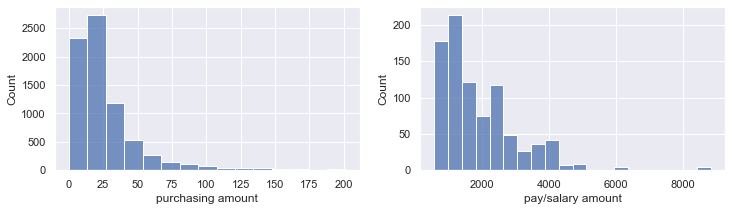

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
q_high2 = df_pur['amount'].quantile(0.98)
sns.histplot(df_pur[df_pur['amount']<q_high2]['amount'], bins=15, ax=axes[0])
sns.histplot(df_sal['amount'], bins=20, ax=axes[1])
axes[0].set_xlabel('purchasing amount')
axes[1].set_xlabel('pay/salary amount')

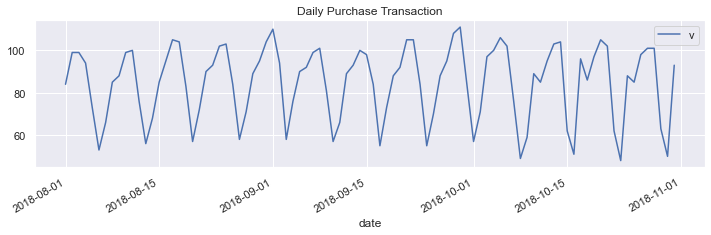

In [35]:
df_pur.groupby('date').agg({'transaction_id':'count'}).plot(figsize=(12, 3))
plt.title('Daily Purchase Transaction')
plt.legend('volume')

Text(0.5, 1.0, 'Daily Salary Transaction')

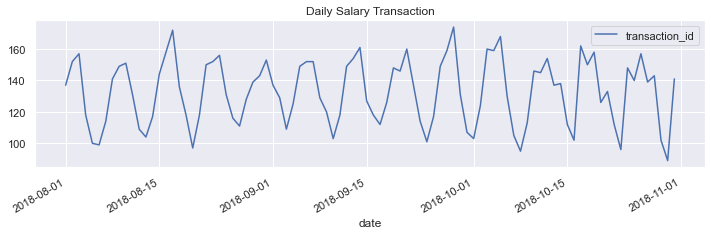

In [36]:
df.groupby('date').agg({'transaction_id':'count'}).plot(figsize=(12, 3))
plt.title('Daily Purchase Transaction')
plt.title('Daily Salary Transaction')

Text(0.5, 1.0, 'pay/salary transaction by week')

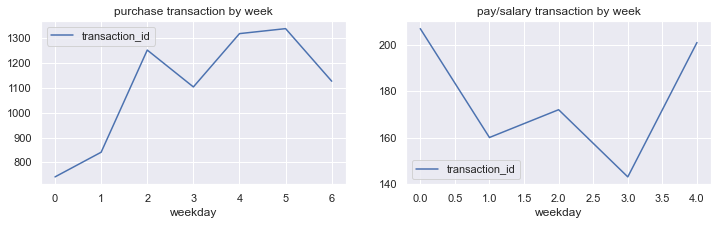

In [37]:
# transaction volume by weekday
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df_pur.groupby('weekday').agg({'transaction_id':'count', 'amount':'sum'}).plot(y='transaction_id', ax=axes[0])
df_sal.groupby('weekday').agg({'transaction_id':'count', 'amount':'sum'}).plot(y='transaction_id', ax=axes[1])
axes[0].set_title('purchase transaction by week')
axes[1].set_title('pay/salary transaction by week')

Text(0.5, 1.0, 'pay/salary transaction by hour')

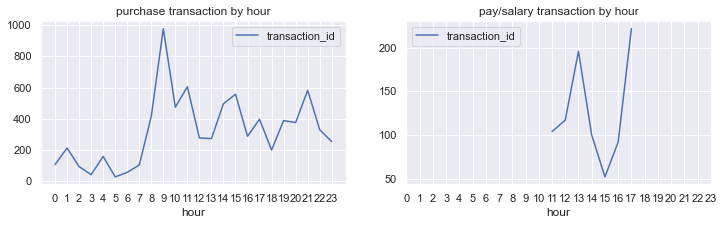

In [38]:
# transaction volume by hour
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df_pur.groupby('hour').agg({'transaction_id':'count', 'amount':'sum'}).plot(y='transaction_id', ax=axes[0])
df_sal.groupby('hour').agg({'transaction_id':'count', 'amount':'sum'}).plot(y='transaction_id', ax=axes[1])
axes[0].set_xticks(np.arange(min(df['hour']), max(df['hour'])+1, 1.0))
axes[1].set_xticks(np.arange(min(df['hour']), max(df['hour'])+1, 1.0))
axes[0].set_title('purchase transaction by hour')
axes[1].set_title('pay/salary transaction by hour')

### Location

Text(0, 0.5, 'volume')

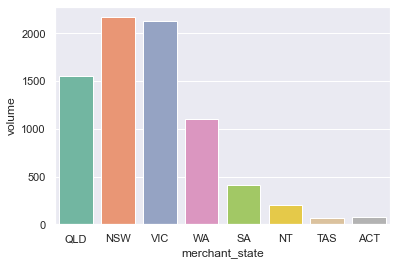

In [39]:
# purchasing transaction volume by state
sns.countplot(data=df_pur, x='merchant_state', palette='Set2')
plt.ylabel('volume')

In [40]:
df['merchant_long_lat'].head()

0    153.38 -27.99
1    151.21 -33.87
2    151.21 -33.87
3    153.05 -26.68
4    153.44 -28.06
Name: merchant_long_lat, dtype: object

In [41]:
df[['long', 'lat']] = df['long_lat'].str.split(' ', expand=True)
df[['long_m', 'lat_m']] = df['merchant_long_lat'].str.split(' ', expand=True)

In [42]:
df.iloc[:,-4:] = df.iloc[:,-4:].astype('float')

In [43]:
df.query('not(lat>(-44) & lat<(-10) & long>113 & long<154)')[['first_name', 'lat', 'long']].value_counts()

first_name  lat     long 
Daniel      -573.0  255.0    123
dtype: int64

>There is one customer who lives outside Australia, but the transaction occurred in Australia.

In [44]:
# define the function to calculate haversine distance
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [45]:
# create 'dist' column containing the haversine distance between customer and merchant
df['dist'] =  haversine_np(df['long'], df['lat'], df['long_m'], df['lat_m'])

In [46]:
df['dist'].describe()

count     7717.000000
mean       561.941949
std       1365.945663
min          0.000000
25%         15.110447
50%         29.978086
75%        298.932674
max      10890.446460
Name: dist, dtype: float64

Text(0.5, 0, 'distance (km)')

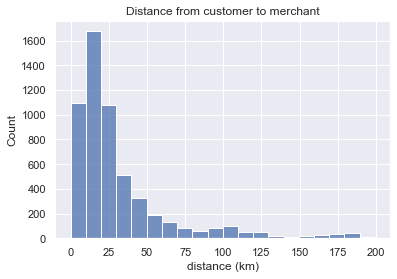

In [47]:
# distribution of distance
sns.histplot(df[df['dist']<200]['dist'], bins=20)
plt.title('Distance from customer to merchant')
plt.xlabel('distance (km)')

#### Purchasing transaction destination map - interactive visualisation

[Link to Tableau Public](https://public.tableau.com/app/profile/aver6639/viz/ANZ_purchasing_transaction_destination_map/Dashboard1?publish=yes)

In [48]:
# export modified data
df.to_csv('ANZ transaction_final.csv')